In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from data_loaders.load_graph_nmr_chpeaks import graph_nmr_data_2d_peak, custom_collate_fn

from GraphModel.GNN_2d_hsolvent import GNNNodeEncoder, NodeEncodeInterface
from torch.utils.data import DataLoader
from torch_geometric.data import Data, Batch
import time
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import rdMolDraw2D

### Load model

In [2]:
# load 2d GNN model
num_layers = 5
hidden_channels = 512
c_out_hidden = [128, 64]
h_out_hidden = [128, 64]
h_sol_emb_dim = 32
c_sol_emb_dim = 16
nodeEncoder = GNNNodeEncoder(num_layers, hidden_channels, JK="last", gnn_type='gin', aggr='add')
model = NodeEncodeInterface(nodeEncoder, hidden_channels=hidden_channels, c_out_hidden=c_out_hidden,\
             h_out_hidden=h_out_hidden, solvent_emb_dim = h_sol_emb_dim, \
                h_out_channels=2, use_solvent=True)

msg = model.load_state_dict(torch.load(
    'ckpt/model_2dnmr.pt'\
      ,map_location='cpu'))
print(msg)

<All keys matched successfully>


### evaluate expert annotateed test set

In [34]:
graph_path = '/Users/siriusxiao/Documents/Github/2DNMR_data/graph_3d/'
csv_file = './data_csv/2dnmr/all_files_testdata_solvent_mw.csv'
nmr_path = '/Users/siriusxiao/Documents/Github/2dNMR/2dnmr_annotation_check/test_data_500_to_validate/Final_To_Shared_Folder/Annotation'

df = pd.read_csv(csv_file)

loss = []
model.eval()

checked_list = os.listdir(nmr_path)

rslt_df = pd.DataFrame(columns=list(df.columns) + ['closs', 'hloss'])
# evaluate test and log loss to csv
for i in range(len(df)):
    tmp = df.iloc[i, :].copy()
    if tmp['File_name'] in checked_list:
        file = tmp['File_name'].split('.')[0]
        mol_graph = pickle.load(open(os.path.join(graph_path, '%s.pickle'%file),'rb'))
        mol_graph.has_c = True
        mol_graph.has_h = True
        mol_graph.batch = torch.zeros([len(mol_graph.x)], dtype=int)
        mol_graph.solvent_class = torch.tensor(tmp['solvent_class'])
        mol_graph_list = [mol_graph]  # Since it's just one molecule, we wrap it in a list
        mol_graph_batch = Batch.from_data_list(mol_graph_list)
        [c_shifts, h_shifts], ch_idx = model(mol_graph_batch)

        c_shifts = c_shifts.detach().numpy() * 200
        h_shifts = h_shifts.detach().numpy() * 10

        gt = pd.read_csv(os.path.join(nmr_path, '%s.csv'%file))
        gt = gt.sort_values(by='c_idx') # the corrected alignment results in c_idx not in ascending order
        gt = gt[['C', 'H 1', 'H 2']].values

        closs = np.mean(np.abs(c_shifts - gt[:, 0:1]))
        hloss = np.mean(np.abs(h_shifts - gt[:, 1:]))
        tmp['closs'] = closs
        tmp['hloss'] = hloss
        rslt_df = pd.concat([rslt_df, tmp.to_frame().T])

In [35]:
print(np.mean(rslt_df['hloss']))
print(np.mean(rslt_df['closs']))

0.1650616026206961
2.024873905991943


### Visualize one result

In [30]:
file

'31927'

In [36]:
import cairosvg
def draw_2d_graph_cindex(smile, filename):
    mol = Chem.MolFromSmiles(smile)
    # mol_with_h = Chem.AddHs(mol)  # Ensure hydrogens are added if they are in the prediction
    AllChem.Compute2DCoords(mol)

    # Create a drawer with desired size
    drawer = rdMolDraw2D.MolDraw2DSVG(400, 400)

    opts = drawer.drawOptions()
    # Show atom indices for carbon atoms
    for atom in mol.GetAtoms():
        if atom.GetSymbol() == 'C':
            # print(atom.GetIdx())
            opts.atomLabels[atom.GetIdx()] = str(atom.GetIdx())

    # Draw the molecule with highlighted carbons
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()

    svg = drawer.GetDrawingText()

    # svg_content = svg.replace('svg', '')
    svg_content = svg.replace('xmlns:svg="http://www.w3.org/2000/svg" ', '')
    # display(SVG(svg.replace('svg:', '')))

    # Save SVG content to a PNG file using cairosvg
    cairosvg.svg2png(bytestring=svg_content.encode('utf-8'), write_to=filename)

In [37]:
file_path = os.path.join('./figures', '%s_molecule.png'%file)
smile = df[df['File_name'] == file+'.csv']['SMILES'].values[0]
draw_2d_graph_cindex(smile, file_path)

In [38]:
smile

'[H]OC1=C(OC([H])([H])[H])C([H])=C(C([H])=C1OC([H])([H])[H])C(=O)OC([H])([H])[C@]1(O[H])C([H])([H])O[C@@]([H])(O[C@@]2([H])[C@]([H])(OC3=C(OC([H])([H])[H])C([H])=C4C([H])=C([H])C(=O)OC4=C3[H])O[C@]([H])(C([H])([H])O[H])[C@@]([H])(O[H])[C@]2([H])O[H])[C@]1([H])O[H]'

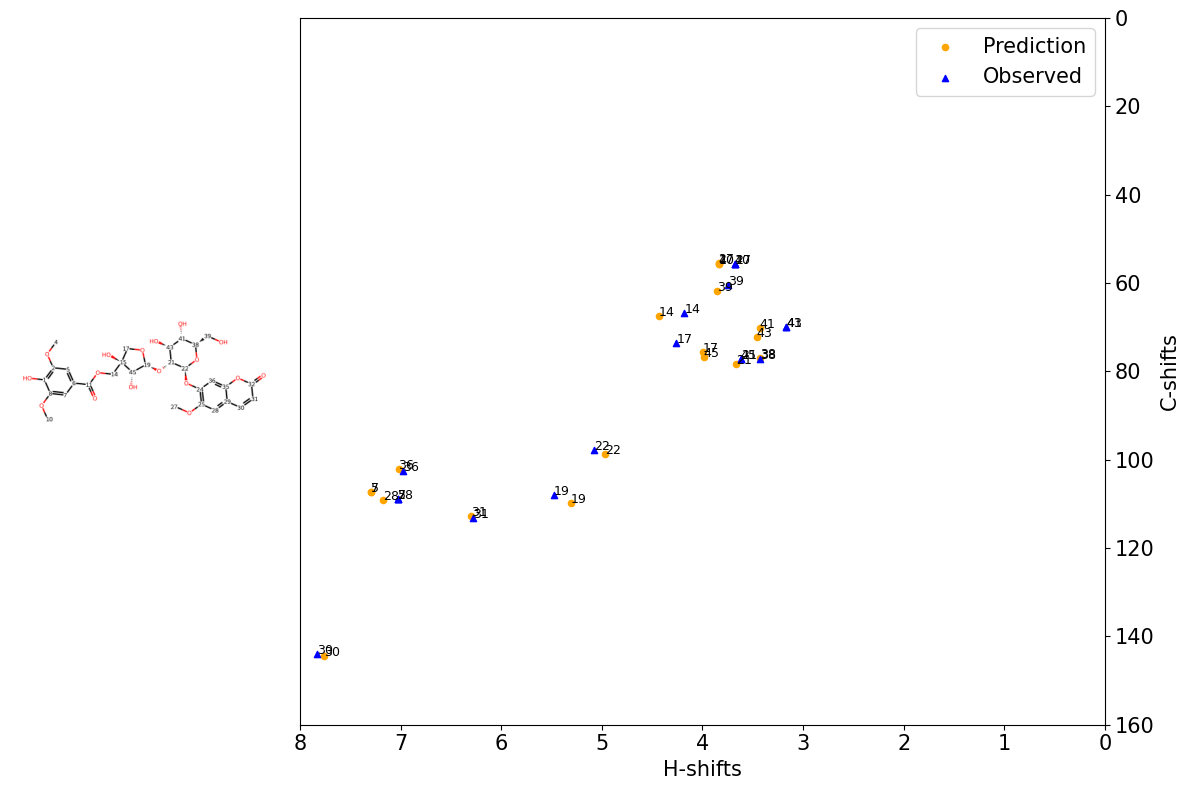

In [40]:
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

h_shifts = np.mean(h_shifts, axis=1, keepdims=True)
# Load the molecular graph
img = mpimg.imread(file_path)

ch_idx = np.array(ch_idx)

marker_size = 20
title_size = 15
label_size = 15
tick_size = 15

# Create a figure and specify the grid
fig = plt.figure(figsize=(12, 8))  # You can adjust the overall size of the figure
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3])  # Width ratios between the two plots

# First subplot
ax1 = fig.add_subplot(gs[0])
ax1.imshow(img)
ax1.axis('off')

# Second subplot
ax2 = fig.add_subplot(gs[1])
ax2.scatter(h_shifts, c_shifts,  c='orange', s=marker_size, marker='o', label='Prediction')
# Add C index as label to the prediction point
for j in range(len(ch_idx)):
    ax2.text(h_shifts[j, 0] , c_shifts[j, 0] , f'{ch_idx[j]}', fontsize=9)


ax2.scatter(gt[:, 1], gt[:, 0], c='blue', s=marker_size, marker='^', label='Observed')
for j in range(ch_idx.shape[0]):
    ax2.text(gt[j, 1], gt[j, 0], f'{ch_idx[j]}', fontsize=9)

ax2.set_xlim(0, 8)
ax2.set_ylim(0, 160)
ax2.set_xlabel('H-shifts', fontsize=label_size)
ax2.set_ylabel('C-shifts', fontsize=label_size)

ax2.tick_params(axis='both', which='major', labelsize=tick_size)
ax2.tick_params(axis='y', which='both', labelleft=False, labelright=True)
ax2.invert_xaxis()
ax2.invert_yaxis()
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax2.legend(fontsize=title_size)

plt.tight_layout()
plt.show()

fig.savefig(os.path.join('./figures', '%s_pred_gt.png'%file))